**Maximum likelihood estimatation from observed and unobserved data**

You are given a bag containing red and blue coins. All the red coins have the same probability of heads. All the blue coins have the same probability of heads (possibly different from that of the red coins).

Your task is to estimate the proportion of red coins in the bag and the probability of heads for both the red and the blue coin.

In [5]:
import ipywidgets as widgets
prob_red = widgets.FloatSlider(min=0.0, max=1.0, description='prob_red')
prob_head_red = widgets.FloatSlider(min=0.0, max=1.0, description='head_red')
prob_head_blue = widgets.FloatSlider(min=0.0, max=1.0, description='head_blue')
display(prob_red, prob_head_red, prob_head_blue)

FloatSlider(value=0.0, description='prob_red', max=1.0)

FloatSlider(value=0.0, description='head_red', max=1.0)

FloatSlider(value=0.0, description='head_blue', max=1.0)

Use these widgets to control the model.

In [6]:
import random
def choose_coin():
    return 'R' if random.random() < prob_red.value else 'B'

def flip_coin(coin):
    uar = random.random()
    if coin == 'R':
        if uar < prob_head_red.value:
            return 'H'
    elif uar < prob_head_blue.value:
        return 'H'
    return 'T'

def flip_random_coin_n_times(n, hidden=False):
    coin = choose_coin()
    return ('_' if hidden else coin, ''.join([flip_coin(coin) for i in range(n)]))

def flip_m_random_coins_n_times(m, n, hidden=False):
    return [flip_random_coin_n_times(n, hidden) for i in range(m)]

Use the above methods to sample from the model. The optional parameter 'hidden' controls whether the colour of the coin is observed in the samples.

In [7]:
flip_m_random_coins_n_times(5, 100)

[('R',
  'TTHTTTTTHHHTHTTTHHHTTTTTTHHTTTTHTTTTTTTTTHTTHTTTTTTTTTHTTTHTHTHTTTTHTHTTTTTTTTHTTTTTHTTTHTTHHTTTTTTT'),
 ('B',
  'HTTHTTHHTHHHHHHHTHHHHHHHTHHHHHHHHHHHHHHHHHHHHTHHTHHHHHTTHHHTHTHHHHHHTHHTTHHHHHHHHHTHTHHHTHHTHHHHHHHH'),
 ('B',
  'HHHHHTHHHHHHHHHHTHHHHHHHHHHHHHHHHHHHHHHTTHTTTHHHHHHHHHTHTHHTHHHTHHHTHTTHHHTHHHHHHHHTHHHHHTHTHTTTHHHH'),
 ('B',
  'HHTHHHTHTTHHHHTHHHHHHHHTTHHHHHHHHHHHTHHHHHTHTHHHHHHHHHHHHHTTHHHHHHHHHHHHHHHTHHHTHTHTHHTHTHHHTHHHHTHH'),
 ('R',
  'TTTTTTTHTHTTTHTTHHTTHTHHTHTHHTTTTHTHTHTHHTTTTTTHTHTHTTHTTTTTHTTTHHHTTTTHTTTTTTTTHTTHTHTHTTHHTTTTHHHT')]

In [8]:
flip_m_random_coins_n_times(5, 100, hidden=True)

[('_',
  'THHTHHTHHHHTHHHHHHHHHTHTHHHHTHHHHHHTHHHHHHTHTHHHHHTHHHHHHTHHTTHHHTTHTHHHHHHHHHTHTHHTTHHHHHTHHHHHHHHH'),
 ('_',
  'THTTTHTTTTTTHTHTTTHHHHTTHTTTHTTHTTTTTTTHHTTTTTHHTTTTTTHHTHTTHTTTHTHHHHTTHTTHTTTTHHTTTTHHTTTHTTHTTHHT'),
 ('_',
  'THHHTTHTHTHHTHTHHTHHTTHHHHHHHHTHHHHHTHHHHHHHHTHHHTHHHTHTHHHHHHHHTHTHTTHTHHHTHHHHHHHHHHHHHHHHHTHHHHHH'),
 ('_',
  'TTTTTTTHHTHTTTTTTTHHHTTTHTTHTHTTTHTTTHHTHTHTTHHTTHTHHHTTTHHHHHTTTTTTTTTTHTTHTTHTHTTTTTTTHHTTTHTTTTTT'),
 ('_',
  'HHHHHHHHHHHHHHHHTHHTHHTHHHHHTHHHHHHHHHHHTHHHTHHHTTHHHHHHTHHTHHHHHHHHHHHHTHTHHHHTHHTHHHHHHTTTHTHHHTHH')]

**TASK 1** Implement the following two functions to estimate parameters for the model in the observed case. Splitting the work into two separate functions will simplify things for the next task. 

* How could you measure the error in your estimates?
* How does the error decrease with the sample size?
* If you were only allowed to flip coins a total of N times how would you choose m (the number of coins) and n the number of times to flip each coin? Why?

In [9]:
from collections import Counter
from numpy import unique

def compute_sufficient_statistics(samples):
    m = len(samples)
    n = len(samples[0][1])
    
    colors = (item[0] for item in samples)

    get_seq = lambda color: (item for sample in samples for item in sample[1] if sample[0] == color)
    red = get_seq('R')
    blue = get_seq('B')
    
    return m, n, Counter(colors)['R'], Counter(red)['H'], Counter(blue)['H']

def mle(m, n, red_num, red_head_num, blue_head_num):
    return red_num / m, red_head_num / red_num / n, blue_head_num / (m - red_num) / n

In [10]:
samples = flip_m_random_coins_n_times(10000, 1000)
statistics = compute_sufficient_statistics(samples)
mle(*statistics)

(0.4009, 0.300020703417311, 0.7999060257052245)

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')
sns.set()

In [12]:
from numpy import logspace
from collections import namedtuple

statistics = namedtuple('Statistics', [
    'sample_size', 'colour_proba_error', 'red_head_proba_error', 'blue_head_proba_error'
])(logspace(1, 6, num=6), [], [], [])

for sample_size in statistics.sample_size:
    samples = flip_m_random_coins_n_times(int(sample_size), 1)
    colour_proba, red_head_proba, blue_head_proba = mle(*compute_sufficient_statistics(samples))
    mse = lambda true, pred: abs(true.value - pred)
    statistics.colour_proba_error.append(mse(prob_red, colour_proba))
    statistics.red_head_proba_error.append(mse(prob_head_red, red_head_proba))
    statistics.blue_head_proba_error.append(mse(prob_head_blue, blue_head_proba))

In [13]:
from numpy import log10

statistics = statistics._asdict()

grid = log10(statistics['sample_size'])
del statistics['sample_size']

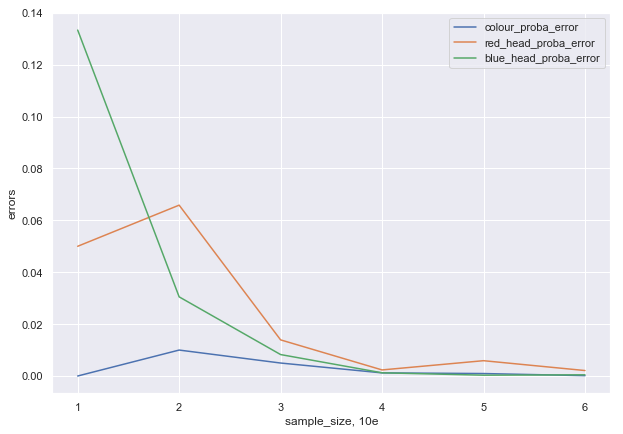

In [14]:
plt.figure(figsize=(10, 7))
for key, value in statistics.items():
    plt.plot(grid, value, label=key)
    
plt.xlabel('sample_size, 10e')
plt.ylabel('errors')
plt.legend()
plt.show()

* Since we are trying to estimate probabilities, error can be measured with continious metrics like MSE (but logMSE is more preferable).
* See the plot.
* I would flipped as much coins with different colours as possible in order to get more information about distribution of colours without losing information about head-tail distribution of each colour. To get information about head-tail distribution, we need to compute statistics within each colour, and average size of such group will be about $probability\_of\_colour * m * n$. But $m * n = N$, so we've got $probability\_of\_colour * N$. But this does not depend on m, that's why we can maximize it.

**TASK 2** Given a sample from a single coin whose colour is unobserved, estimate the posterior probability that the coin is red, given some estimates of the model parameters.

* If you pass in the true model parameters (e.g. prob_red.value, prob_head_red.value and prob_head_blue.value), how quickly does the posterior change? Use the plot_distribution function to view this.
* How does this depend on the model parameters?

In [15]:
def compute_posterior_prob_red(sample, estimate_prob_red, estimate_prob_head_red, estimate_prob_head_blue):
    n_head = sample.count('H')
    n_tail = len(sample) - n_head
    
    red_proba = estimate_prob_red * estimate_prob_head_red ** n_head * (1 - estimate_prob_head_red) ** n_tail
    blue_proba = (1 - estimate_prob_red) * estimate_prob_head_blue ** n_head * (1 - estimate_prob_head_blue) ** n_tail
    
    return red_proba / (red_proba + blue_proba)

**TASK 3** Reusing your code from Tasks 1 and 2, implement expectation maximization algorithm to find a (locally optimal) solution to the parameters when the colour of the coins is not observed.

In [16]:
def compute_expected_statistics(samples, estimate_prob_red, estimate_prob_head_red, estimate_prob_head_blue):
    m = len(samples)
    n = len(samples[0][1])
    
    expected_red_num, expected_red_head_num, expected_blue_head_num = 0, 0, 0
    
    for sample in samples:
        posterior_red_proba = compute_posterior_prob_red(
            sample[1], estimate_prob_red, estimate_prob_head_red, estimate_prob_head_blue)
        
        expected_red_num += posterior_red_proba
        expected_red_head_num += posterior_red_proba * sample[1].count('H')
        expected_blue_head_num += (1 - posterior_red_proba) * sample[1].count('H')
        
    return m, n, expected_red_num, expected_red_head_num, expected_blue_head_num

def expectation_maximization(samples, iterations, estimate_prob_red, estimate_prob_head_red, estimate_prob_head_blue):
    for _ in range(iterations):
        mle_params = compute_expected_statistics(
            samples, estimate_prob_red, estimate_prob_head_red, estimate_prob_head_blue)
        estimate_prob_red, estimate_prob_head_red, estimate_prob_head_blue = mle(*mle_params)
        
        print(estimate_prob_red, estimate_prob_head_red, estimate_prob_head_blue, end='\n')

In [17]:
samples = flip_m_random_coins_n_times(1000, 1000, hidden=True)
expectation_maximization(samples, 5, 0.5, 0.3, 0.7)

0.403 0.3002406947890819 0.7998978224455612
0.403 0.3002406947890819 0.7998978224455612
0.403 0.3002406947890819 0.7998978224455612
0.403 0.3002406947890819 0.7998978224455612
0.403 0.3002406947890819 0.7998978224455612
